The Sloan Digital Sky Survey is a project which offers public data of space observations.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [137]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import (
    LogisticRegression,
    Ridge
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import  SequentialFeatureSelector

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # to avoid warnings

# EDA

In [106]:
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/projects/boosting_model_eval/Skyserver_SQL2_27_2018+6_51_39+PM.csv"
dataset = pd.read_csv(url)

## Basic stats about our dataset

Let's take a first look at our dataset to see what we're working with! Display the first lines of the dataset and basic statistics.

In [107]:
dataset.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [108]:
print(f'Number of rows: {dataset.shape[0]}')
print(f'Number of columns: {dataset.shape[1]}')
print()

data_desc = dataset.describe(include="all")
print(f'Desc of shape: \n{data_desc}')
print()


Number of rows: 10000
Number of columns: 18

Desc of shape: 
               objid            ra           dec             u             g  \
count   1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    1.237650e+18    175.529987     14.836148     18.619355     17.371931   
std     0.000000e+00     47.783439     25.212207      0.828656      0.945457   
min     1.237650e+18      8.235100     -5.382632     12.988970     12.799550   
25%     1.237650e+18    157.370946     -0.539035     18.178035     16.815100   
50%     1.237650e+18    180.394514      0.404166     18.853095     17.495135   
75%     1.237650e+18    201.547279     35.649397     19.259232     18.010145   
max     1.237650e+18    260.884382     68.542265     19.599

In [109]:
# missing values
missing_values = dataset.isnull().sum() / dataset.shape[0] * 100
print(f"missing values for each column: \n{missing_values}")

missing values for each column: 
objid        0.0
ra           0.0
dec          0.0
u            0.0
g            0.0
r            0.0
i            0.0
z            0.0
run          0.0
rerun        0.0
camcol       0.0
field        0.0
specobjid    0.0
class        0.0
redshift     0.0
plate        0.0
mjd          0.0
fiberid      0.0
dtype: float64


We can tell that we have all the features as described in the above query.

We notice that there are no categorical features at all - besides the class column. As some machine learning models can't handle categorical feature columns at all, we will encode this column to be a numerical column later on.

Let's find out about the types of columns we have:

In [110]:
# types of columns:
dataset.dtypes

objid        float64
ra           float64
dec          float64
u            float64
g            float64
r            float64
i            float64
z            float64
run            int64
rerun          int64
camcol         int64
field          int64
specobjid    float64
class         object
redshift     float64
plate          int64
mjd            int64
fiberid        int64
dtype: object

From the above table we can tell that are no missing values at all. This means: no imputing!

Most variables do not show any outliers.

How is the target distributed?

In [111]:
dataset["class"]

0         STAR
1         STAR
2       GALAXY
3         STAR
4         STAR
         ...  
9995    GALAXY
9996    GALAXY
9997      STAR
9998    GALAXY
9999    GALAXY
Name: class, Length: 10000, dtype: object

In [112]:
# Comptage des valeurs absolues et des proportions
counts = dataset["class"].value_counts()
percentages = dataset["class"].value_counts(normalize=True) * 100

# Combiner les deux dans un DataFrame pour un affichage clair
distribution = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages
})

print(distribution)

        Count  Percentage (%)
class                        
GALAXY   4998           49.98
STAR     4152           41.52
QSO       850            8.50


The most objects (50%) are galaxies, a little less (40%) are stars and only around (10%) of the rows are classified as QSOs.

## First Data Filtering

There is no need to know everything about stars, galaxy or quasars - yet we can already tell which features are unlikely to be related to the target variable 'class'.

objid and specobjid are just identifiers, we will not need them for classification.

The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera when gathering observations, they do not describe caracteristics of the observed object e.g. 'run' represents the corresponding scan which captured the oject.

Drop all the unnecessary features.

In [113]:
columns_to_drop = [
    'objid',
    'specobjid',
    'run',
    'rerun',
    'camcol',
    'field'
]

dataset_cleaned = dataset.drop(columns=columns_to_drop)

dataset_cleaned.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


## Univariate Analysis

Redshift

Compare the distributions of redshift for the different classes of objects

In [114]:
# Boîte à moustaches (Boxplot) pour visualiser la distribution du redshift par classe
fig_box = px.box(
    dataset_cleaned, 
    y='class', 
    x='redshift', 
    title='Redshift Distribution by Class', 
    labels={'redshift': 'Redshift', 'class': 'Class'}
)
fig_box.show()

# Histogramme pour visualiser la distribution du redshift avec la répartition des classes
fig_hist = px.histogram(
    dataset_cleaned, 
    x='redshift', 
    color='class', 
    range_x=[0, 1], 
    range_y=[0, 5000], 
    nbins=180,  # Ajustez le nombre de bins pour une meilleure granularité
    title='Redshift Histogram by Class', 
    labels={'redshift': 'Redshift', 'count': 'Count'}
)
fig_hist.show()

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ.

Star: The histogram looks like a truncated zero-centered normal distribution.

Galaxy: The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

QSO: The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.

The redshift can be an estimate(!) for the distance from the earth to a object in space.

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.

Possible rookie explanation: Since galaxies and quasars radiate stronger due to their size and physical structure, they can be observed from further away than "small" stars.

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

Plot the distribution of the values of dec (position on celestial equator) for the different classes

In [115]:
# Boîte à moustaches (Boxplot) pour visualiser la distribution du redshift par classe
fig_box = px.box(
    dataset_cleaned, 
    y='class', 
    x='dec', 
    title='Dec Distribution by Class', 
    labels={'dec': 'dec', 'class': 'Class'}
)
fig_box.show()

# Histogramme pour visualiser la distribution du redshift avec la répartition des classes
fig_hist = px.histogram(
    dataset_cleaned, 
    x='dec', 
    color='class', 
    range_x=[0, 1], 
    range_y=[0, 5000], 
    nbins=180,  # Ajustez le nombre de bins pour une meilleure granularité
    title='Dec Histogram by Class', 
    labels={'dec': 'dec', 'count': 'Count'}
)
fig_hist.show()

First of all: what does this plot tell us?

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.

Star: The largest part of the data points lay within a 0 to 10 range. Another large part consists of values between about 10 to 55. Only small amounts of the data are lower or higher than these ranges.

Galaxy: The largest part of values lays between 0 and 45. There is a smaller amount of values in the range of 45 to 60. The rest of the data has smaller or higher values.

QSO: This plot looks quite similiar to the GALAXY plot. Only the amount of data points in the range of 0 to 60 is even bigger.

Side Note: The fact that the distribution of dec values of galaxies and quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.

## Multivariate Analysis

u,g,r,i,z filters

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations.

Plot the correlation matrix of these variables for the different classes

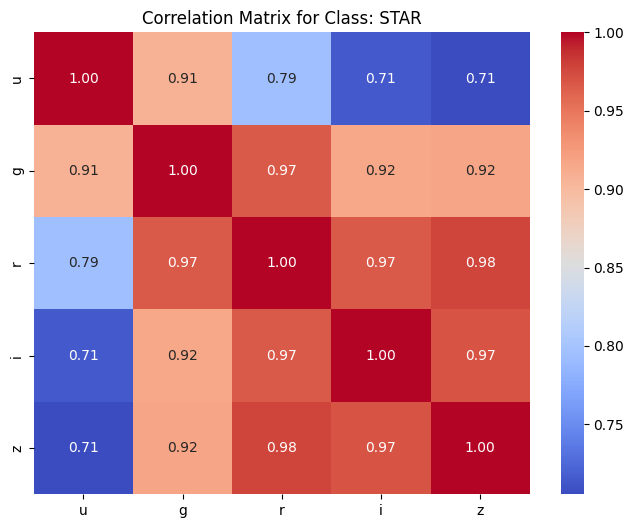

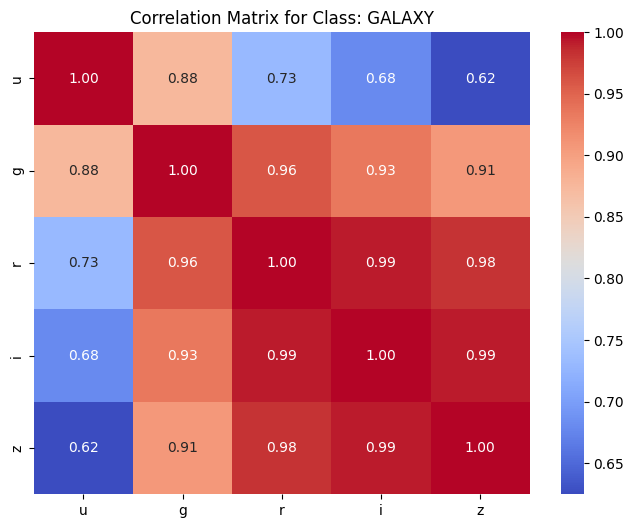

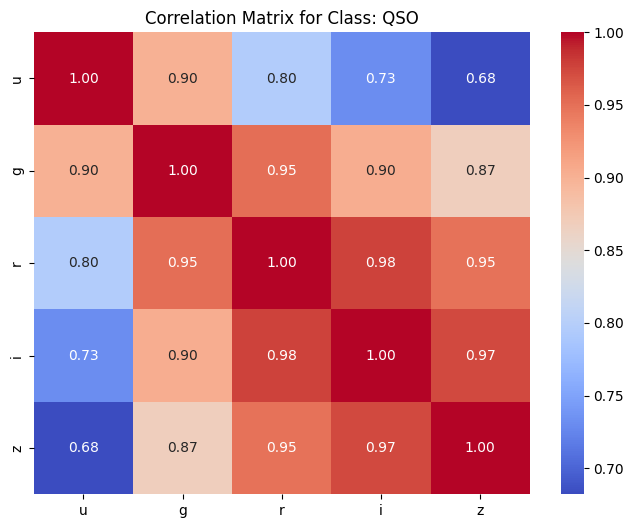

In [116]:
# Exemple de données : Filtrer uniquement les colonnes d'intérêt et inclure la classe
filter_columns = ['u', 'g', 'r', 'i', 'z', 'class']
filtered_dataset = dataset_cleaned[filter_columns]

# Boucle pour créer une matrice de corrélation par classe
classes = filtered_dataset['class'].unique()

for cls in classes:
    subset = filtered_dataset[filtered_dataset['class'] == cls]
    correlation_matrix = subset.drop(columns='class').corr()

    # Tracer la matrice de corrélation
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f", 
        cbar=True
    )
    plt.title(f"Correlation Matrix for Class: {cls}")
    plt.show()

The correlation matrices look very similiar for every class.

There are high correlations between the different bands. Intuitively one would think that if one of the bands captures some signal emitted by a celestial object, the other bands should capture some signal.

Remember: u, g, r, i, z capture light at wavelengths of 354, 476, 628, 769 and 925 nm.

The correlation are similar across the different categories, the different bands behave the same for the different classes!

Right ascension (ra) and declination (dec)

Plot the right ascension versus the declination depending on the class

In [117]:
# Création du graphique de dispersion
fig = px.scatter(
    dataset_cleaned,
    x='ra',
    y='dec',
    color='class',
    title='Sky Observations by Class',
    labels={'ra': 'Right Ascension (RA)', 'dec': 'Declination (Dec)', 'class': 'Object Class'},
    template='plotly_dark',  # Thème optionnel pour une meilleure lisibilité
    opacity=0.8  # Rendre les points légèrement transparents pour éviter les chevauchements excessifs
)

# Afficher le graphique
fig.show()

What this graph shows is that the three different categories of space objects are not clusterised spatially.

Why is that?

All SDSS images cover the same area of the sky. The plot above tells us that stars, galaxies and quasars are observed equally at all coordinates within this area. So wherever the SDSS "looks" - the chance of observing a star or galaxy or quasar is always the same.

# Preprocessing

In [118]:
# Separate target variable Y from features X
print("Separating labels from features...")

X = dataset_cleaned.drop(columns=["class"], axis= 1)
Y = dataset_cleaned["class"]

print("Y (Target variable):")
print(Y.head())
print("\nX (Features):")
print(X.head())


X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    train_size=0.2,
    random_state=0,
    stratify= Y)

Separating labels from features...
Y (Target variable):
0      STAR
1      STAR
2    GALAXY
3      STAR
4      STAR
Name: class, dtype: object

X (Features):
           ra       dec         u         g         r         i         z  \
0  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342  15.22531   
1  183.598370  0.135285  18.66280  17.21449  16.67637  16.48922  16.39150   
2  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732  16.80125   
3  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233  15.90438   
4  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492  16.61326   

   redshift  plate    mjd  fiberid  
0 -0.000009   3306  54922      491  
1 -0.000055    323  51615      541  
2  0.123111    287  52023      513  
3 -0.000111   3306  54922      510  
4  0.000590   3306  54922      512  


Make the necessary preprocessings

In [119]:
# Prétraitement de X_train
print("Preprocessing X_train...")
print("Initial X_train sample:")
print(X_train.head())
print()

# Standardisation des données
preprocessor = StandardScaler()
X_train = preprocessor.fit_transform(X_train)

print("Preprocessing completed!")
print("Transformed X_train sample:")
print(X_train[0:5, :])  # Affichage des 5 premières lignes transformées
print()

# Encodage des labels
print("Encoding labels...")
print("Initial Y_train sample:")
print(Y_train.head())
print()

# Encodage des étiquettes
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)

print("Encoding completed!")
print("Encoded Y_train sample:")
print(Y_train[:5])  # Affichage des 5 premières étiquettes encodées


Preprocessing X_train...
Initial X_train sample:
              ra        dec         u         g         r         i         z  \
6386  162.320811   0.329333  16.51262  14.90060  14.14002  13.76013  13.43570   
4031  160.873248   1.237466  19.39831  18.23954  17.60842  17.25526  17.08514   
7313  238.643894  53.612910  17.48361  15.63938  14.82809  14.45045  14.15943   
1252  150.526295   1.104413  17.91676  16.96593  16.72930  16.60566  16.56816   
976    24.139159  13.558743  19.59971  18.03099  17.34425  16.93693  16.69568   

      redshift  plate    mjd  fiberid  
6386  0.040614    276  51909      392  
4031  0.119955    506  52022       92  
7313  0.048958    618  52049      587  
1252  0.000640    501  52235      208  
976   0.110046    426  51882      235  

Preprocessing completed!
Transformed X_train sample:
[[-0.26471803 -0.56893249 -2.48189907 -2.57312406 -2.48770888 -2.45681167
  -2.46952862 -0.26081211 -0.64397569 -0.66503246  0.19015492]
 [-0.29456713 -0.53280691  0.9420

In [120]:
# Prétraitement de X_test
print("Preprocessing X_test...")
print("Initial X_test sample:")
print(X_test.head())
print()

# Transformation des données avec le préprocesseur existant
X_test = preprocessor.transform(X_test)

print("Preprocessing completed!")
print("Transformed X_test sample:")
print(X_test[0:5, :])  # Affichage des 5 premières lignes transformées
print()

# Encodage des labels pour Y_test
print("Encoding labels...")
print("Initial Y_test sample:")
print(Y_test.head())
print()

# Transformation des étiquettes avec l'encodeur existant
Y_test = encoder.transform(Y_test)

print("Encoding completed!")
print("Encoded Y_test sample:")
print(Y_test[:5])  # Affichage des 5 premières étiquettes encodées

Preprocessing X_test...
Initial X_test sample:
              ra       dec         u         g         r         i         z  \
649   187.077507  0.066863  17.94245  16.66657  16.10645  15.87961  15.73977   
4028  160.771285  1.243478  19.42950  17.89946  17.24946  16.88993  16.65983   
1168  166.949134 -0.932675  18.75355  17.81158  17.47550  17.67501  17.28985   
8722  186.851335  0.998054  17.24831  15.87916  15.32995  15.13808  15.04006   
860   239.543230 -0.087878  17.27711  15.93447  15.97800  16.05394  16.06975   

      redshift  plate    mjd  fiberid  
649   0.000225   2558  54140      595  
4028  0.072430    275  51910      326  
1168 -0.000297    278  51900      220  
8722 -0.000031   2558  54140      614  
860   0.000164    343  51692      156  

Preprocessing completed!
Transformed X_test sample:
[[ 0.24577102 -0.57937353 -0.7853862  -0.71812238 -0.65844895 -0.59462345
  -0.54375028 -0.36376757  0.63308986  0.81973513  1.1771266 ]
 [-0.29666963 -0.53256776  0.97901899  0.5

## Baseline model

Create a baseline (linear model with all features) and evaluate its performances

In [121]:
baseline = LogisticRegression(max_iter = 1000)
baseline.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [122]:
# Prédictions sur l'ensemble d'entraînement
print("Making predictions on the training set...")
Y_train_pred = baseline.predict(X_train)
print("Predictions on training set completed!")
print("Training set predictions:")
print(Y_train_pred[:10])  # Afficher les 10 premières prédictions pour un aperçu
print()

# Prédictions sur l'ensemble de test
print("Making predictions on the test set...")
Y_test_pred = baseline.predict(X_test)
print("Predictions on test set completed!")
print("Test set predictions:")
print(Y_test_pred[:10])  # Afficher les 10 premières prédictions pour un aperçu
print()

Making predictions on the training set...
Predictions on training set completed!
Training set predictions:
[0 0 0 2 0 2 2 2 2 0]

Making predictions on the test set...
Predictions on test set completed!
Test set predictions:
[2 0 2 2 2 0 0 0 2 0]



In [123]:
# Calcul et affichage des scores
print("Evaluating model performance...")

# Précision (Accuracy)
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Accuracy on training set: {train_accuracy:.4f}")
print(f"Accuracy on test set: {test_accuracy:.4f}")
print()

# F1-Score (Macro Moyenne)
train_f1 = f1_score(Y_train, Y_train_pred, average='macro')
test_f1 = f1_score(Y_test, Y_test_pred, average='macro')
print(f"F1-score on training set (macro average): {train_f1:.4f}")
print(f"F1-score on test set (macro average): {test_f1:.4f}")
print()

Evaluating model performance...
Accuracy on training set: 0.9690
Accuracy on test set: 0.9641

F1-score on training set (macro average): 0.9651
F1-score on test set (macro average): 0.9603



In [124]:
# Rapport de classification pour l'ensemble d'entraînement
print("Classification Report on Training Set:")
train_report = classification_report(Y_train, Y_train_pred, target_names=encoder.classes_)
print(train_report)
print()

# Rapport de classification pour l'ensemble de test
print("Classification Report on Test Set:")
test_report = classification_report(Y_test, Y_test_pred, target_names=encoder.classes_)
print(test_report)

Classification Report on Training Set:
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97      1000
         QSO       0.98      0.93      0.95       170
        STAR       0.96      0.98      0.97       830

    accuracy                           0.97      2000
   macro avg       0.97      0.96      0.97      2000
weighted avg       0.97      0.97      0.97      2000


Classification Report on Test Set:
              precision    recall  f1-score   support

      GALAXY       0.97      0.95      0.96      3998
         QSO       0.97      0.94      0.95       680
        STAR       0.95      0.98      0.97      3322

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000



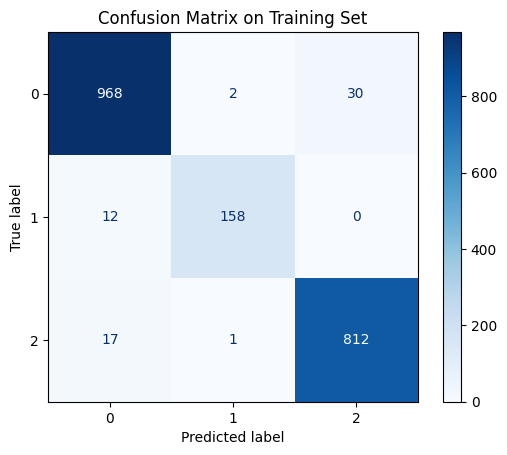

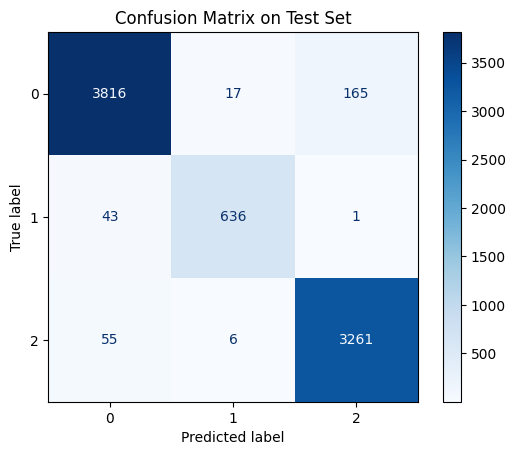

In [125]:
# Matrice de confusion pour l'ensemble d'entraînement
fig, ax = plt.subplots()
ax.set(title="Confusion Matrix on Training Set")  # Définir le titre
ConfusionMatrixDisplay.from_estimator(
    estimator=baseline,
    X=X_train,
    y=Y_train,
    ax=ax,
    cmap='Blues',  # Optionnel : ajouter une palette de couleurs
    colorbar=True  # Afficher une barre de couleurs
)
plt.show()

# Matrice de confusion pour l'ensemble de test
fig, ax = plt.subplots()
ax.set(title="Confusion Matrix on Test Set")  # Définir le titre
ConfusionMatrixDisplay.from_estimator(
    estimator=baseline,
    X=X_test,
    y=Y_test,
    ax=ax,
    cmap='Blues',  # Optionnel : ajouter une palette de couleurs
    colorbar=True  # Afficher une barre de couleurs
)
plt.show()

The baseline is already really good at classifying the objects!

Is the model underfitting/overfitting? Make what's necessary to be sure the score differences are significant.

In [126]:
# Validation croisée avec 10 plis
val_scores = cross_val_score(baseline, X_train, Y_train, cv=10)

# Affichage des résultats
print("Cross-Validated Model Performance:")
print(f"Average cross-validated accuracy: {val_scores.mean():.4f}")
print(f"Standard deviation of cross-validated accuracy: {val_scores.std():.4f}")

Cross-Validated Model Performance:
Average cross-validated accuracy: 0.9655
Standard deviation of cross-validated accuracy: 0.0091


The uncertainty on the test accuracy is about 0.005, so the model's overfitting a bit but it's not really a big issue (0.978 vs 0.967 is not a big difference anyway)

Analyze the model's coefficients. Which feature is the most important?

In [127]:
# Obtenir les noms des colonnes
column_names = X.columns
print("Names of columns corresponding to each coefficient:")
print(column_names)
print()

# Créer un DataFrame avec les coefficients
coefs = pd.DataFrame(
    data=baseline.coef_[0].transpose(),
    index=column_names,
    columns=["Coefficients"]
)

# Affichage des coefficients triés
print("Coefficients corresponding to each column:")
coefs_sorted = coefs.sort_values(by="Coefficients", ascending=False)  # Optionnel : trier par valeur absolue
print(coefs_sorted)

Names of columns corresponding to each coefficient:
Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'mjd',
       'fiberid'],
      dtype='object')

Coefficients corresponding to each column:
          Coefficients
redshift      3.674176
u             0.728635
r             0.410044
g             0.088738
dec           0.087735
ra            0.058688
fiberid      -0.060112
mjd          -0.260361
i            -0.451834
plate        -0.474604
z            -1.241347


In [128]:
# Calcul de l'importance absolue des coefficients et tri par ordre décroissant
feature_importance = coefs.copy()
feature_importance["Absolute Coefficients"] = abs(coefs["Coefficients"])
feature_importance_sorted = feature_importance.sort_values(by="Absolute Coefficients", ascending=False)

# Affichage des résultats triés
print("Feature importance based on absolute coefficient values:")
feature_importance_sorted

Feature importance based on absolute coefficient values:


,Coefficients,Absolute Coefficients
redshift,3.674176,3.674176
z,-1.241347,1.241347
u,0.728635,0.728635
plate,-0.474604,0.474604
i,-0.451834,0.451834
r,0.410044,0.410044
mjd,-0.260361,0.260361
g,0.088738,0.088738
dec,0.087735,0.087735
fiberid,-0.060112,0.060112


In [129]:
# Tracé des coefficients sous forme de barres horizontales
fig = px.bar(
    feature_importance_sorted,
    x="Absolute Coefficients",
    y=feature_importance_sorted.index,
    orientation='h',
    title="Feature Importance (Absolute Coefficients)",
    labels={"Absolute Coefficients": "Importance", "index": "Features"}  # Étiquettes personnalisées
)

# Mise à jour de la mise en page
fig.update_layout(
    showlegend=False,  # Masquer la légende (inutile pour un seul ensemble de données)
    margin={'l': 200},  # Augmenter la marge gauche pour éviter de couper les noms des colonnes
    height=600  # Ajuster la hauteur pour plus de lisibilité
)

# Affichage du graphique
fig.show()

We're rediscovering a very famous fact in Astrophysics: the redshift is very important to classify objects!

# Feature selection

Use SequentialFeatureSelector to implement a forward selection. Try to reduce the number of features to 3 and train the baseline once again. Are the model's performances still as good as before?

In [130]:
# Vérifier si X_train est déjà un DataFrame, sinon le convertir
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)  # Utiliser les noms de colonnes de X d'origine

# Création de l'objet SequentialFeatureSelector
feature_selector = SequentialFeatureSelector(
    estimator=baseline,
    n_features_to_select=3,
    direction='forward',  # Par défaut, sélection "forward" (ajout progressif de features)
    scoring=None,         # Par défaut, utilise la métrique de score du modèle
    cv=5,                 # Validation croisée à 5 plis
    n_jobs=-1             # Utilisation parallèle pour accélérer le calcul
)

# Ajustement du sélecteur sur les données d'entraînement
feature_selector.fit(X_train, Y_train)

# Extraction des noms des features sélectionnés
features_list = X_train.columns  # Colonnes des features
best_features = features_list[feature_selector.support_]  # Features sélectionnés

# Affichage des résultats
print("According to the forward selection algorithm, the following features should be kept:")
print(best_features.to_list())

According to the forward selection algorithm, the following features should be kept:
['g', 'redshift', 'plate']


In [131]:
# Réduction du DataFrame aux colonnes sélectionnées
X_reduced = X.loc[:, ['g', 'redshift', 'plate']]

# Division du jeu de données en ensembles d'entraînement et de test
print("Dividing dataset into train and test sets...")
# Ne pas oublier d'utiliser stratify pour les problèmes de classification
X_train_reduced, X_test_reduced, Y_train_reduced, Y_test_reduced = train_test_split(
    X_reduced, 
    Y, 
    test_size=0.2, 
    random_state=0, 
    stratify=Y
)
print("...Done.")
print()

# Prétraitement de X_train_reduced
print("Preprocessing X_train_reduced...")
print("Initial X_train_reduced sample:")
print(X_train_reduced.head())
print()

preprocessor = StandardScaler()  # Standardisation des données
X_train_reduced = preprocessor.fit_transform(X_train_reduced)

print("Preprocessing completed!")
print("Transformed X_train_reduced sample:")
print(X_train_reduced[0:5, :])  # Affichage des 5 premières lignes transformées
print()

# Encodage des labels pour Y_train_reduced
print("Encoding labels for training set...")
print("Initial Y_train_reduced sample:")
print(Y_train_reduced.head())
print()

encoder = LabelEncoder()  # Encodage des étiquettes
Y_train_reduced = encoder.fit_transform(Y_train_reduced)

print("Encoding completed!")
print("Encoded Y_train_reduced sample:")
print(Y_train_reduced[:5])  # Affichage des 5 premières étiquettes encodées
print()

# Prétraitement de X_test_reduced
print("Preprocessing X_test_reduced...")
print("Initial X_test_reduced sample:")
print(X_test_reduced.head())
print()

X_test_reduced = preprocessor.transform(X_test_reduced)

print("Preprocessing completed!")
print("Transformed X_test_reduced sample:")
print(X_test_reduced[0:5, :])  # Affichage des 5 premières lignes transformées
print()

# Encodage des labels pour Y_test_reduced
print("Encoding labels for test set...")
print("Initial Y_test_reduced sample:")
print(Y_test_reduced.head())
print()

Y_test_reduced = encoder.transform(Y_test_reduced)

print("Encoding completed!")
print("Encoded Y_test_reduced sample:")
print(Y_test_reduced[:5])  # Affichage des 5 premières étiquettes encodées

Dividing dataset into train and test sets...
...Done.

Preprocessing X_train_reduced...
Initial X_train_reduced sample:
             g  redshift  plate
749   18.81006  2.511341   4037
9986  17.91853  0.093830    445
7608  17.57919  0.066298    495
8477  17.66109  0.057130    423
1216  17.09897  0.000125   3826

Preprocessing completed!
Transformed X_train_reduced sample:
[[ 1.52286141  5.94894989  1.44590591]
 [ 0.57854142 -0.13316719 -0.56885589]
 [ 0.21910815 -0.20243423 -0.54081077]
 [ 0.30585768 -0.22550011 -0.58119575]
 [-0.28954703 -0.36891619  1.32755548]]

Encoding labels for training set...
Initial Y_train_reduced sample:
749        QSO
9986    GALAXY
7608    GALAXY
8477    GALAXY
1216      STAR
Name: class, dtype: object

Encoding completed!
Encoded Y_train_reduced sample:
[1 0 0 0 2]

Preprocessing X_test_reduced...
Initial X_test_reduced sample:
             g  redshift  plate
9668  18.07072  0.000891    285
8182  17.90759  0.000090   2558
3749  17.94113 -0.000165   3133
79

In [132]:
baseline_reduced = LogisticRegression(max_iter = 1000)
baseline_reduced.fit(X_train_reduced, Y_train_reduced)

LogisticRegression(max_iter=1000)

In [134]:
# Prédictions sur l'ensemble d'entraînement
print("Making predictions on the training set...")
Y_train_pred = baseline_reduced.predict(X_train_reduced)
print("Predictions on training set completed!")
print("Training set predictions:")
print(Y_train_pred[:10])  # Afficher les 10 premières prédictions pour un aperçu
print()

# Prédictions sur l'ensemble de test
print("Making predictions on the test set...")
Y_test_pred = baseline_reduced.predict(X_test_reduced)
print("Predictions on test set completed!")
print("Test set predictions:")
print(Y_test_pred[:10])  # Afficher les 10 premières prédictions pour un aperçu
print()

# Calcul et affichage des scores
print("Evaluating model performance...")

# Précision (Accuracy)
train_accuracy = accuracy_score(Y_train_reduced, Y_train_pred)
test_accuracy = accuracy_score(Y_test_reduced, Y_test_pred)
print(f"Accuracy on training set: {train_accuracy:.4f}")
print(f"Accuracy on test set: {test_accuracy:.4f}")
print()

# F1-Score (Macro Moyenne)
train_f1 = f1_score(Y_train_reduced, Y_train_pred, average='macro')
test_f1 = f1_score(Y_test_reduced, Y_test_pred, average='macro')
print(f"F1-score on training set (macro average): {train_f1:.4f}")
print(f"F1-score on test set (macro average): {test_f1:.4f}")
print()

Making predictions on the training set...
Predictions on training set completed!
Training set predictions:
[1 0 0 0 2 2 0 2 2 2]

Making predictions on the test set...
Predictions on test set completed!
Test set predictions:
[2 2 2 2 2 2 0 0 2 0]

Evaluating model performance...
Accuracy on training set: 0.9774
Accuracy on test set: 0.9655

F1-score on training set (macro average): 0.9656
F1-score on test set (macro average): 0.9461



The scores are a bit deteriorated but still very good!

# Non-linear model

By using all the features, try a non-linear model. Does it improves the performances?

Making predictions on the training set...
Training set predictions completed!
[0 0 0 2 0 2 2 2 2 0]

Making predictions on the test set...
Test set predictions completed!
[2 0 2 2 2 0 0 0 2 0]

Evaluating model performance...
Accuracy on training set: 0.9415
Accuracy on test set: 0.9351

F1-score on training set (macro average): 0.9431
F1-score on test set (macro average): 0.9359

Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1000
           1       0.99      0.91      0.95       170
           2       0.95      0.93      0.94       830

    accuracy                           0.94      2000
   macro avg       0.95      0.93      0.94      2000
weighted avg       0.94      0.94      0.94      2000


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3998
           1       0.98      0.90      0.94       6

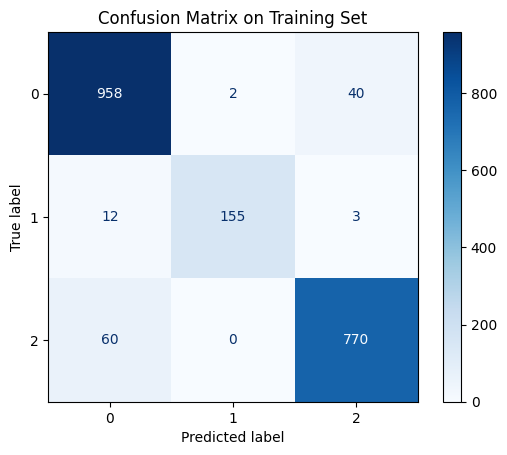

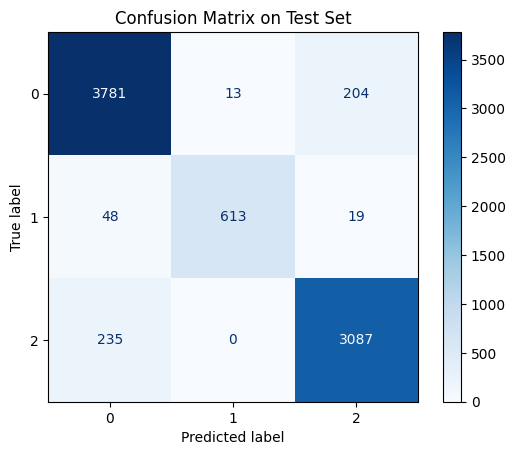

In [135]:
# Création et entraînement du modèle SVM
svm = SVC(kernel='rbf', random_state=0)  # Kernel RBF avec un seed pour la reproductibilité
svm.fit(X_train, Y_train)

# Prédictions sur l'ensemble d'entraînement
print("Making predictions on the training set...")
Y_train_pred = svm.predict(X_train)
print("Training set predictions completed!")
print(Y_train_pred[:10])  # Afficher les 10 premières prédictions pour un aperçu
print()

# Prédictions sur l'ensemble de test
print("Making predictions on the test set...")
Y_test_pred = svm.predict(X_test)
print("Test set predictions completed!")
print(Y_test_pred[:10])  # Afficher les 10 premières prédictions pour un aperçu
print()

# Évaluation des scores
print("Evaluating model performance...")

# Précision
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Accuracy on training set: {train_accuracy:.4f}")
print(f"Accuracy on test set: {test_accuracy:.4f}")
print()

# F1-Score
train_f1 = f1_score(Y_train, Y_train_pred, average='macro')
test_f1 = f1_score(Y_test, Y_test_pred, average='macro')
print(f"F1-score on training set (macro average): {train_f1:.4f}")
print(f"F1-score on test set (macro average): {test_f1:.4f}")
print()

# Rapport de classification
print("Classification Report on Training Set:")
print(classification_report(Y_train, Y_train_pred))
print()
print("Classification Report on Test Set:")
print(classification_report(Y_test, Y_test_pred))
print()

# Visualisation des matrices de confusion
# Matrice de confusion pour l'ensemble d'entraînement
fig, ax = plt.subplots()
ax.set(title="Confusion Matrix on Training Set")
ConfusionMatrixDisplay.from_estimator(svm, X_train, Y_train, ax=ax, cmap='Blues')
plt.show()

# Matrice de confusion pour l'ensemble de test
fig, ax = plt.subplots()
ax.set(title="Confusion Matrix on Test Set")
ConfusionMatrixDisplay.from_estimator(svm, X_test, Y_test, ax=ax, cmap='Blues')
plt.show()

Depending on what model you chose, the model might be overfitting. If it's the case, make what's necessary to solve the problem.

In [136]:
# Initialisation du modèle SVM avec kernel RBF
print("Performing grid search...")
svm = SVC(kernel='rbf', probability=True, random_state=0)

# Grille de paramètres à tester
params = {
    'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0],  # Paramètre de régularisation
    'gamma': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]  # Coefficient du kernel RBF
}

# Configuration de la recherche par grille avec validation croisée
svm_opt = GridSearchCV(
    estimator=svm,
    param_grid=params,
    cv=3,  # Validation croisée à 3 plis
    verbose=1,  # Afficher la progression
    n_jobs=-1  # Utilisation parallèle pour accélérer
)

# Entraînement avec GridSearch
svm_opt.fit(X_train, Y_train)

# Résultats
print("...Done.")
print(f"Best hyperparameters: {svm_opt.best_params_}")
print(f"Best validation accuracy: {svm_opt.best_score_:.4f}")
print()
print(f"Accuracy on training set: {svm_opt.score(X_train, Y_train):.4f}")
print(f"Accuracy on test set: {svm_opt.score(X_test, Y_test):.4f}")

Performing grid search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
...Done.
Best hyperparameters: {'C': 5.0, 'gamma': 0.05}
Best validation accuracy: 0.9585

Accuracy on training set: 0.9795
Accuracy on test set: 0.9663


# Ensemble methods
Implement a voting of your linear and non-linear models. Does it improve the scores?

In [138]:
# Création du VotingClassifier
voting = VotingClassifier(
    estimators=[
        ("logistic", baseline),  # Régression logistique comme premier modèle
        ("svm", svm)  # SVM comme deuxième modèle
    ],
    voting='soft'  # Utiliser les probabilités pour la pondération des votes
)

# Entraînement du VotingClassifier sur les données d'entraînement
voting.fit(X_train, Y_train)

# Évaluation des performances
train_accuracy = voting.score(X_train, Y_train)
test_accuracy = voting.score(X_test, Y_test)

# Affichage des résultats
print("Voting Classifier Performance:")
print(f"Accuracy on training set: {train_accuracy:.4f}")
print(f"Accuracy on test set: {test_accuracy:.4f}")

Voting Classifier Performance:
Accuracy on training set: 0.9595
Accuracy on test set: 0.9525


The generalized performances are not improved compared to the non-linear model, so we'd better keep the SVM alone.